# Choropleth Mapping

## Introduction

In this notebook, we’ll explore how to create a choropleth map using population data by county. [Choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map) are thematic maps where areas are shaded or patterned in proportion to a variable of interest, in this case, population data. These maps help visualize spatial distributions and identify patterns, such as population density variations across geographic areas.

This notebook will use NHGIS population data by county based on the 2020 US Decennial Census.

## 1. Setup

Before running this script, you will need to install and load the following packages into your R environment:

[**dplyr**](https://cran.r-project.org/web/packages/dplyr/index.html) A package for data manipulation that provides a consistent set of functions to filter, arrange, summarize, and transform data. *dplyr* makes it easy to work with data frames and perform operations efficiently.  This notebook uses the the following functions from *dplyr*.

* [*mutate()*](https://dplyr.tidyverse.org/reference/mutate.html) for modifying dataframes
* [*rename()*](https://dplyr.tidyverse.org/reference/rename.html) for changing the names of individual variables in a dataframe
* This notebook also uses [*%>%*](https://magrittr.tidyverse.org/reference/pipe.html), referred to as the *pipe* operator, which is used to pass the output from one function directly into the next function for the purpose of creating streamlined workflows.  The *pipe* operator is a commonly used component of the [*tidyverse*](https://www.tidyverse.org).

[**ggplot2**](https://cran.r-project.org/web/packages/ggplot2/index.html) A package for creating graphics based on the "Grammar of Graphics".  This notebook uses the following functions from *ggplot2*.

* [*geom_sf()*](https://ggplot2.tidyverse.org/reference/ggsf.html) for visualizing (mapping) sf objects

[**ipumsr**](https://cran.r-project.org/web/packages/ipumsr/index.html) A package specifically designed to interact with IPUMS datasets, including NHGIS. It allows users to define and submit data extraction requests, download data, and read it directly into R for analysis.  This notebook uses the the following functions from *ipumsr*.

* *set_ipums_api_key()* for setting your IPUMS API key
* *define_extract_nhgis()* for defining an IPUMS NHGIS extract request
* *submit_exract()* for submitting an extract request via the IPUMS API and return an *ipums_extract* object
* *wait_for_extract()* wait for an extract to finish processing
* *download_extract()* download an extract's data files
* *read_nhgis()* for reading tabular data from an NHGIS extract
* *read_ipums_sf()* for reading spatial data from an IPUMS extract

[**sf**](https://cran.r-project.org/web/packages/sf/index.html) A package providing support for simple features (sf) geometry objects, a standardized way to encode spatial vector data.  This notebook uses the following functions from *sf*.

* [*st_area()*](https://r-spatial.github.io/sf/reference/geos_measures.html) for computing the area or the length of a set of geometries
* [*st_as_sf()*](https://r-spatial.github.io/sf/reference/st_as_sf.html) for converting a foreign object on a sf object
* [*st_make_valid()*](https://r-spatial.github.io/sf/reference/valid.html) for checking whether geometry is valid or making an invalid geometry valid
* [*st_transform()*](https://r-spatial.github.io/sf/reference/st_transform.html) for transforming or converting coordinates of simple feature

If you are working in the I-GUIDE environment, these packages should be already be installed.  However you will still need to load the packages into your workspace using *library* base R function.

In [44]:
library(dplyr)
library(ipumsr)
library(ggplot2)
library(sf)

Linking to GEOS 3.12.0, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE



Run the following code to enter your [IPUMS API key](https://account.ipums.org/api_keys).

In [ ]:
my_ipumps_api_key = readline("Please enter your IPUMS API key: ")
set_ipums_api_key(my_ipumps_api_key, save = T, overwrite = T)

## 2. Data Extraction

In [35]:
extraction <- define_extract_nhgis(description = "I-GUIDE IPUMS Population Change Extraction",
                                   time_series_tables = tst_spec(name = "CL8",
                                                                 geog_levels = "county",
                                                                 years = "2020"),
                                   shapefiles = "us_county_2010_tl2010")

In [36]:
# submit extraction  
extraction_submitted <- submit_extract(extraction)

# wait for completion
extraction_complete <- wait_for_extract(extraction_submitted)

# check completion
extraction_complete$status

# get extraction filepath
filepath <- download_extract(extraction_submitted, overwrite = T)

Successfully submitted IPUMS NHGIS extract number 86

Checking extract status...

Waiting 10 seconds...

Checking extract status...

Waiting 20 seconds...

Checking extract status...

IPUMS NHGIS extract 86 is ready to download.



[1] "completed"

  |======================================================================| 100%
  |======================================================================| 100%


Data file saved to /home/jovyan/pipelines/x - Mapping/nhgis0086_csv.zip
Shapefile saved to /home/jovyan/pipelines/x - Mapping/nhgis0086_shape.zip



In [37]:
# see files in extract
dat_raw <- read_nhgis(filepath[1])
shp_raw <- read_ipums_sf(filepath[2])

Use of data from NHGIS is subject to conditions including that users should cite the data appropriately. Use command `ipums_conditions()` for more details.

Rows: 3143 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): GISJOIN, STATE, STATEA, COUNTY, COUNTYA
dbl (4): GEOGYEAR, CL8AA2020, CL8AA2020L, CL8AA2020U

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [38]:
colnames(dat_raw)

[1] "GISJOIN"    "GEOGYEAR"   "STATE"      "STATEA"     "COUNTY"    
[6] "COUNTYA"    "CL8AA2020"  "CL8AA2020L" "CL8AA2020U"

In [39]:
colnames(shp_raw)

[1] "STATEFP10"  "COUNTYFP10" "COUNTYNS10" "GEOID10"    "NAME10"    
 [6] "NAMELSAD10" "LSAD10"     "CLASSFP10"  "MTFCC10"    "CSAFP10"   
[11] "CBSAFP10"   "METDIVFP10" "FUNCSTAT10" "ALAND10"    "AWATER10"  
[16] "INTPTLAT10" "INTPTLON10" "GISJOIN"    "Shape_area" "Shape_len" 
[21] "geometry"

In [41]:
# subset the time-series data to only necessary columns
dat <- dat_raw[c("GISJOIN", "CL8AA2020")]

# rename population columns
dat <- dat %>% rename("pop2020" = "CL8AA2020")

# subset the shapefile to only necessary columns
shp <- shp_raw[c("GISJOIN", "STATEFP10", "COUNTYFP10")]

# merge the time-series population data with the Censuss tract shapefile
dat_shp <- merge(dat, shp, by = "GISJOIN")

In [42]:
head(dat_shp)

,GISJOIN,pop2020,STATEFP10,COUNTYFP10,geometry
,<chr>,<dbl>,<chr>,<chr>,<MULTIPOLYGON [m]>
1,G0100010,58805,01,001,MULTIPOLYGON (((895625.2 -5...
2,G0100030,231767,01,003,MULTIPOLYGON (((810181.2 -7...
3,G0100050,25223,01,005,MULTIPOLYGON (((1026117 -54...
4,G0100070,22293,01,007,MULTIPOLYGON (((845023.5 -4...
5,G0100090,59134,01,009,MULTIPOLYGON (((886438.3 -3...
6,G0100110,10357,01,011,MULTIPOLYGON (((988747.9 -5...


## 3. Data Preparation

Before mapping, we need to ensure the data is in the correct format and that each geometry is valid. Invalid geometries can prevent accurate area calculation and mapping, so we’ll clean and validate these before moving forward.

First we will convert *dat_shp* to an sf object.

In [45]:
dat_shp <- st_as_sf(dat_shp)

Next we will fix any invalid geometries using st_make_valid() to handle any geometric issues that might interfere with area calculations or plotting.

In [54]:
dat_shp <- st_make_valid(dat_shp)

In this step, we will transform the Coordinate Reference System (CRS) to a standard projection suitable for calculating area.  For this exercise, we will use the CRS 4326.

In [55]:
dat_shp <- st_transform(dat_shp, crs = 4326)

## 4. Calculating Population Density

Population data is often more informative when normalized by area. In this step, we’ll calculate population density for each tract as the number of people per square kilometer. This allows us to compare population concentrations across areas of different sizes.

In the next line of code we first calculate the area of each tract in square kilometers using st_area(), converting the units to numeric values to simplify further calculations.  Then we calculate population density (pop_density) as the total population (pop2020) divided by the area in square kilometers.  And finally, we convert pop_density to a plain numeric variable (without units), which avoids potential issues when visualizing data with ggplot2.

In [64]:
# calculate area in square kilometers and population density
dat_shp <- dat_shp %>%
  mutate(area_km2 = as.numeric(st_area(.) / 1e6),     # convert area to square kilometers
         pop_density = pop2020 / area_km2)            # population density per sq km

# remove units from pop_density
dat_shp <- dat_shp %>%
  mutate(pop_density = as.numeric(pop_density))       # convert to numeric to remove units

## 4. Basic Choropleth Mapping with ggplot2

With our data prepared and population density calculated, we can now map the population density across tracts. ggplot2 and geom_sf() allow us to map the polygons by filling each tract according to total population (pop2020), using a gradient color scale to represent low to high population counts.  In this step we do the following:

1. Use geom_sf(aes(fill = pop_density)) to color each tract based on 2020 population (pop2020).
2. Use scale_fill_viridis_c() to apply a colorblind-friendly gradient scale for the population count.
3. Limit the map view to the contiguous United States using coord_sf() with specified latitude and longitude bounds, focusing the map and removing excess whitespace.

This produces a clear choropleth map that allows users to easily identify areas of high and low population density across the U.S.

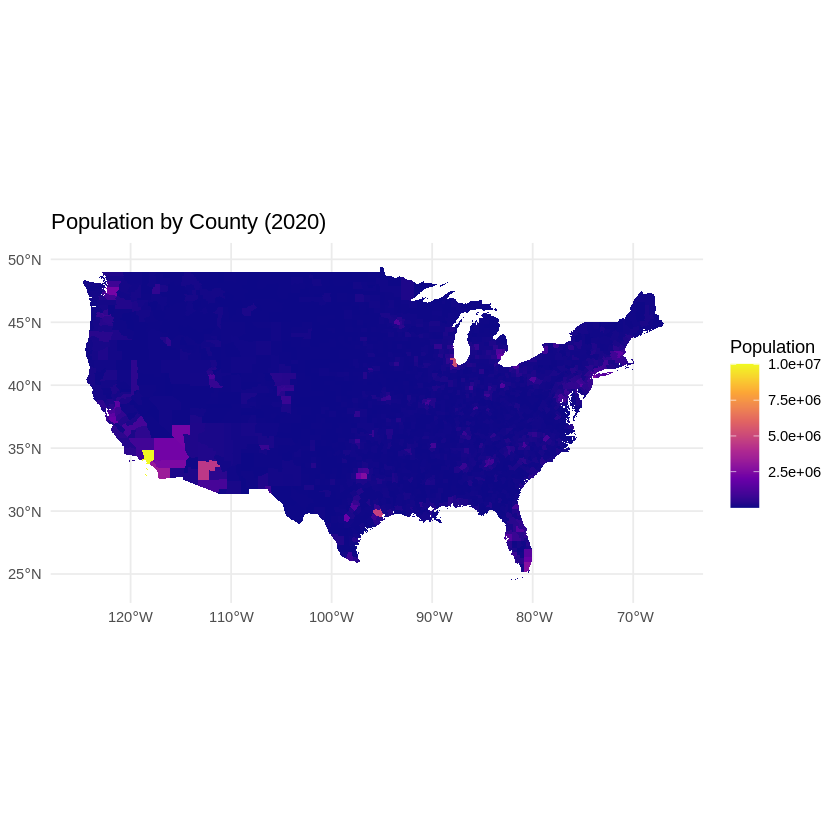

In [68]:
ggplot(data = dat_shp) +
  geom_sf(aes(fill = pop2020), color = NA) +
  scale_fill_viridis_c(option = "plasma", na.value = "grey50") +     # use a colorblind-friendly scale
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50)) +                  # limit to the contiguious United States
  labs(title = "Population by County (2020)", fill = "Population") +
  theme_minimal()

## 5. Mapping Population Density and Customizing the Color Scale and Legend

The population map isn't very informative, so we'll make another version based on population density (pop_density).  To make the map more readable, we will also customize the color scale and legend. For example, using a logarithmic transformation can better capture population density variations, particularly if there’s a wide range between low-density and high-density areas.  In this step we:

1. Apply scale_fill_viridis_c() with a log transformation and specific breaks to improve visual contrast across the density range.
2. Adjust the legend position and add descriptive labels for clarity.

This step helps users interpret the data more effectively by adjusting the color scale to better fit the data’s distribution.

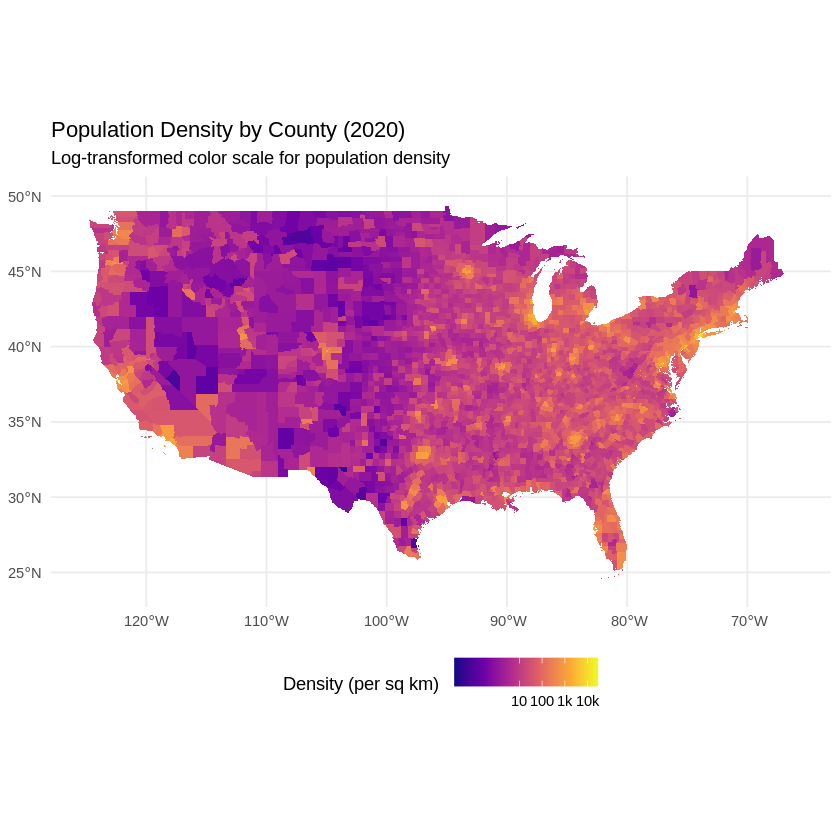

In [70]:
ggplot(data = dat_shp) +
  geom_sf(aes(fill = pop_density), color = NA) +
  scale_fill_viridis_c(option = "plasma", trans = "log",  # Log transformation for density range
                       breaks = c(10, 100, 1000, 10000),  # Adjust breaks as needed
                       labels = c("10", "100", "1k", "10k"),
                       na.value = "grey50") +
  coord_sf(xlim = c(-125, -66), ylim = c(24, 50)) +
  labs(title = "Population Density by County (2020)",
       subtitle = "Log-transformed color scale for population density",
       fill = "Density (per sq km)") +
  theme_minimal() +
  theme(legend.position = "bottom")

The final map reveals spatial patterns of 2020 population density across United States counties. By examining these density patterns, you can identify urban centers (higher population density) and rural areas (lower population density). This information is essential for understanding demographic distributions and can support analyses in public health, urban planning, and environmental impact studies.